In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Loading and Cleaning Data

In [2]:
df = pd.read_csv('recom.csv')

In [3]:
df.shape

(50000, 8)

In [4]:
df.head()

,Unnamed: 0,Main_ID,Transaction_ID,Date,Price,Code_Product,Amount,ItemKey
0,0,90fada91,264f7a69,2022-10-07 20:53:49.153,125.0,5002.0,1.0,5002.0
1,1,9006f9ac,45c7d853,2022-09-17 15:54:57.187,19.0,35012.0,1.0,NaN
2,2,32270891,61ad76dd,2022-11-28 13:51:55.667,141.0,5005.0,1.0,5005.0
3,3,97e03e47,41ee09f6,2022-09-12 16:20:22.110,4.5,35078.5,1.0,NaN
4,4,41949228,244fe6d8,2022-10-14 18:53:43.933,129.5,49291.5,5.0,NaN


In [5]:
# Dropping  Unnamed: 0  column
df.drop('Unnamed: 0', axis=1, inplace=True)

In [6]:
# Check if not null ItemKey = Code_product
df[df['ItemKey'].notnull()].loc[df['ItemKey'] != df['Code_Product']]

,Main_ID,Transaction_ID,Date,Price,Code_Product,Amount,ItemKey


* we can see from above cell that ItemKey =  Code_roduct, so we can drop ItemKey column as it has nulls.

In [6]:
df = df.drop('ItemKey', axis=1)

In [7]:
# Check for null values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Main_ID         50000 non-null  object 
 1   Transaction_ID  50000 non-null  object 
 2   Date            50000 non-null  object 
 3   Price           50000 non-null  float64
 4   Code_Product    50000 non-null  float64
 5   Amount          50000 non-null  float64
dtypes: float64(3), object(3)
memory usage: 2.3+ MB


* Checking if we have the same product for each user in different Transactions to see if we need to aggregate Amount column. By grouping by CustomerKey and Code_Product we can compare number of rows in original dataframe with groupped dataframe. If they are the same, then we do not have the same product in different Transactions.

In [8]:
df.shape[0] == df.groupby(['Main_ID', 'Code_Product']).size().shape[0]

False

* So, we do have the same product for each user in different Transactions, so we need to aggregate Amount column. This will also leave out colums we don't need.

In [9]:
df = df.groupby(['Main_ID', 'Code_Product']).agg({'Amount': 'sum', 'Price' : 'max'}).reset_index()

In [10]:
df.head()

,Main_ID,Code_Product,Amount,Price
0,00024de6,35097.0,2.0,6.0
1,00084856,49291.5,1.0,22.0
2,00084856,49292.0,1.0,24.0
3,0008e848,40002.0,1.0,13.0
4,00096930,49291.5,2.0,48.0


In [11]:
df.shape

(45901, 4)

* Now all data clean and we can start with recommendation system.

### Simple Product-Based Recommender
* Here we will use Correlation coeficient to find similar products.
1. Dropping unnecessary columns.
2. Creating rating for each product per user.
3. Creating correlation matrix for each product.
4. Creating a function to find similar products for all users.

#### Creating rating for each product per user.

In [12]:
df.head()

,Main_ID,Code_Product,Amount,Price
0,00024de6,35097.0,2.0,6.0
1,00084856,49291.5,1.0,22.0
2,00084856,49292.0,1.0,24.0
3,0008e848,40002.0,1.0,13.0
4,00096930,49291.5,2.0,48.0


* Glancing on range of values for Amount column.

In [13]:
s = df['Amount'].unique()
s.sort()
print(s)

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20. 28. 33. 41. 54.]


* We will use Amount column as rating for each product per user. And leave only Main_ID (user), Code_Product (product) and Amount (rating) columns.

In [33]:
df_simple_rec = df.drop(columns=['Price'])

In [34]:
df_simple_rec['Amount'] = df_simple_rec['Amount'].astype(int)

* We also want to drop rows with Amount = 1, as it means that user bought product only once and may not like it. We can't be sure that single purchase can be an indicator of user's preferences.

In [35]:
df_simple_rec.shape

(45901, 3)

In [36]:
df_simple_recommender = df_simple_rec[df_simple_rec['Amount'] > 1].copy(deep=True)
print(df_simple_recommender.shape)
df_simple_recommender.head()

(9951, 3)


,Main_ID,Code_Product,Amount
0,00024de6,35097.0,2
4,00096930,49291.5,2
7,000e98ee,49291.5,2
11,0019e439,5012.0,2
16,001ef3e0,49292.0,2


In [37]:
# renaming columns
df_simple_recommender.rename(columns={'Main_ID': 'user_id', 'Code_Product': 'item_id', 'Amount': 'rating'}, inplace=True)

#### Creating correlation matrix for each product.

In [38]:
df_CM_simple_rec = pd.pivot_table(df_simple_recommender, index='user_id', columns='item_id', values='rating').corr()
df_CM_simple_rec

item_id,5000.5,5001.0,5001.5,5002.0,5003.0,5004.5,5005.0,5007.0,5009.0,5011.5,...,200020.5,200021.0,200021.5,200025.0,200028.0,200029.0,200035.5,200037.0,200037.5,200045.5
item_id,,,,,,,,,,,,,,,,,,,,,
5000.5,1.000000,0.003209,0.109897,0.099158,NaN,4.330127e-01,0.32969,NaN,0.449792,0.083423,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5001.0,0.003209,1.000000,-0.866025,0.237429,NaN,-9.064933e-17,1.00000,NaN,0.034269,0.149071,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5001.5,0.109897,-0.866025,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5002.0,0.099158,0.237429,NaN,1.000000,NaN,NaN,NaN,NaN,-0.391965,0.530947,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5003.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200029.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200035.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
200037.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


* Now we can see what products are similar to each other and if user like product 5011.5, we can see what else we can reccomend to him - 48513.0, 40009.5, 48523.5. If we set arbitrary treshhold to coefficient 0 (line where negative correlation begins)

In [39]:
single_prod_corr = df_CM_simple_rec[5011.5].sort_values(ascending=False)
single_prod_corr.loc[single_prod_corr.values > 0].apply(lambda x: round(x, 2))

item_id
48513.0    1.00
40009.5    1.00
5011.5     1.00
48523.5    1.00
5025.0     1.00
45002.5    1.00
35000.5    1.00
10022.5    0.87
5004.5     0.80
10032.5    0.80
5002.0     0.53
5001.0     0.15
5000.5     0.08
5009.0     0.00
Name: 5011.5, dtype: float64

* Now we can make reccomendations of similar products to all users in our dataset.

In [42]:
rec_dict = {'user_id':[],
            'purchased_item_id':[],
            'reccomended_item':[],
            'correlations_coeff':[]}

for g in df_simple_recommender.groupby('user_id'):
    for i in g[1]['item_id']:
        single_prod_corr = df_CM_simple_rec[i].sort_values(ascending=False)
        positive_single_prod_corr = single_prod_corr.loc[single_prod_corr.values > 0]

        for j in positive_single_prod_corr.index:
            rec_dict['user_id'].append(g[0])
            rec_dict['purchased_item_id'].append(i)
            rec_dict['reccomended_item'].append(j)
            rec_dict['correlations_coeff'].append(positive_single_prod_corr[j])


df_simpl_rec_final = pd.DataFrame(rec_dict)
df_simpl_rec_final['correlations_coeff'] = df_simpl_rec_final['correlations_coeff'].apply(lambda x: round(x, 2))
df_simpl_rec_final.index = pd.MultiIndex.from_arrays([df_simpl_rec_final['user_id'], 
                                                    df_simpl_rec_final['purchased_item_id'],
                                                    df_simpl_rec_final['reccomended_item']])
df_simpl_rec_final.drop(columns=['user_id','purchased_item_id','reccomended_item'], inplace=True)

* Now we have a data frame with all users, purchsed item and items to reccomend to them. Let's see top 10 items for user '0259a8d6' and his purchased item 5000.5. 

In [50]:
df_simpl_rec_final.loc[('0259a8d6',5000.5)].head(10)

,correlations_coeff
reccomended_item,
5000.5,1.00
10002.0,1.00
35106.0,1.00
35097.0,1.00
35096.5,0.94
49356.0,0.82
45003.0,0.77
35000.5,0.60
35076.0,0.53


* In above solution I have not taken into account anything but how many times product was bought by users. So, similatiry of products were only based on how many times they were bought by users. But we can improve our solution by taking into account price of products. So, if user bought 1 product 5007.0 for 1000, and 2 products 5001.5 for 2000, we can see that user prefers products with higher price range. So, we can use price of product as a weight for rating.

#### Product-Based Recommender with Price as a Weight
1. Binning price column for our weights.
2. Creating user profile for particular user.
3. Creating Product Price range Matrix for each product.
4. Using user profile and product price range matrix to find recommended products(User profile*Product Price range Matrix).
5. Creating functions to predict and record in data frame for each user.

In [51]:
df.head(2)

,Main_ID,Code_Product,Amount,Price
0,00024de6,35097.0,2.0,6.0
1,00084856,49291.5,1.0,22.0


* Removing rows with Amount = 1, as it means that user bought product only once and may not like it. We can't be sure that single purchase can be an indicator of user's preferences.

In [70]:
df2 = df[df['Amount'] > 1].copy(deep=True)
print(df2.shape)
df2.head()

(9951, 4)


,Main_ID,Code_Product,Amount,Price
0,00024de6,35097.0,2.0,6.0
4,00096930,49291.5,2.0,48.0
7,000e98ee,49291.5,2.0,94.0
11,0019e439,5012.0,2.0,62.0
16,001ef3e0,49292.0,2.0,66.0


* Let's see how we will bin our price column to use it as a weight for rating.

In [75]:
df_simple_reccomender_w_price = df2.copy(deep=True)
df_simple_reccomender_w_price['Price'].describe()

count    9951.000000
mean       85.052206
std        95.465838
min         0.500000
25%        30.000000
50%        64.500000
75%       115.000000
max      2525.500000
Name: Price, dtype: float64

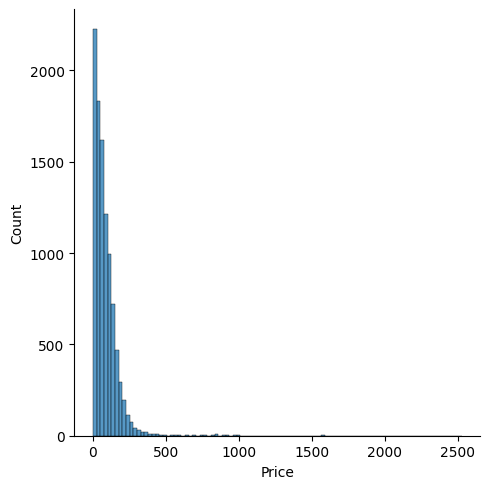

In [76]:
# plot Price distribution
sns.displot(df_simple_reccomender_w_price['Price'], bins=100)

In [77]:
# create Price bins as columns with 1 if item is in bin and 0 if not
df_simple_reccomender_w_price['Price_bin_0-30'] = df_simple_reccomender_w_price['Price'].apply(lambda x: 1 if x < 30 else 0)
df_simple_reccomender_w_price['Price_bin_30-65'] = df_simple_reccomender_w_price['Price'].apply(lambda x: 1 if x >= 30 and x < 65 else 0)
df_simple_reccomender_w_price['Price_bin_65-115'] = df_simple_reccomender_w_price['Price'].apply(lambda x: 1 if x >= 65 and x < 115 else 0)
df_simple_reccomender_w_price['Price_bin_115-max'] = df_simple_reccomender_w_price['Price'].apply(lambda x: 1 if x >= 115 else 0)

In [78]:
df_simple_reccomender_w_price = df_simple_reccomender_w_price.drop('Price', axis=1)

In [79]:
df_simple_reccomender_w_price['Amount'] = df_simple_reccomender_w_price['Amount'].astype(int)
df_simple_reccomender_w_price.head(2)

,Main_ID,Code_Product,Amount,Price_bin_0-30,Price_bin_30-65,Price_bin_65-115,Price_bin_115-max
0,00024de6,35097.0,2,1,0,0,0
4,00096930,49291.5,2,0,1,0,0


In [80]:
df_simple_reccomender_w_price.rename(columns={'Main_ID': 'user_id', 'Code_Product': 'item_id', 'Amount': 'rating'}, inplace=True)
df_simple_reccomender_w_price.head(2)

,user_id,item_id,rating,Price_bin_0-30,Price_bin_30-65,Price_bin_65-115,Price_bin_115-max
0,00024de6,35097.0,2,1,0,0,0
4,00096930,49291.5,2,0,1,0,0


In [81]:
df_simple_reccomender_w_price.shape

(9951, 7)

#### Creating user Profile for single user

In [82]:
df_simple_reccomender_w_price.head()

,user_id,item_id,rating,Price_bin_0-30,Price_bin_30-65,Price_bin_65-115,Price_bin_115-max
0,00024de6,35097.0,2,1,0,0,0
4,00096930,49291.5,2,0,1,0,0
7,000e98ee,49291.5,2,0,0,1,0
11,0019e439,5012.0,2,0,1,0,0
16,001ef3e0,49292.0,2,0,0,1,0


* We need to create Multi level index in order to easily access data for each user. Same time only leaving data we need to manipulate in the dataframe body.

In [83]:
df_simple_reccomender_w_price.index = pd.MultiIndex.from_arrays([df_simple_reccomender_w_price['user_id'],
                                                                df_simple_reccomender_w_price['item_id']] )
df_SRWP_ready = df_simple_reccomender_w_price.drop(columns=['user_id','item_id'])
df_SRWP_ready.head()

,,rating,Price_bin_0-30,Price_bin_30-65,Price_bin_65-115,Price_bin_115-max
user_id,item_id,,,,,
00024de6,35097.0,2,1,0,0,0
00096930,49291.5,2,0,1,0,0
000e98ee,49291.5,2,0,0,1,0
0019e439,5012.0,2,0,1,0,0
001ef3e0,49292.0,2,0,0,1,0


* Choosing a single user to create user profile

In [89]:
#inding someone to work with
df_SRWP_ready[df_SRWP_ready['rating'] > 3].head()

rating  Price_bin_0-30  Price_bin_30-65  Price_bin_65-115  \
user_id  item_id                                                              
00767d3a 10013.0       5               0                0                 0   
00b94ff5 45000.5       5               0                0                 0   
00e7053f 5000.5        5               0                0                 1   
         49292.0       4               0                0                 1   
01896e92 35000.5       4               1                0                 0   

                  Price_bin_115-max  
user_id  item_id                     
00767d3a 10013.0                  1  
00b94ff5 45000.5                  1  
00e7053f 5000.5                   0  
         49292.0                  0  
01896e92 35000.5                  0

In [90]:
userItemTable = df_SRWP_ready.loc[('00e7053f')].copy(deep=True)
userItemTable

,rating,Price_bin_0-30,Price_bin_30-65,Price_bin_65-115,Price_bin_115-max
item_id,,,,,
5000.5,5,0,0,1,0
49292.0,4,0,0,1,0


* To create user profile  we need to multiply rating by price range for each product. We will use price range as a weight for rating.

In [91]:
userPriceBinColumns = [col for col in userItemTable.columns if 'Price_bin' in col]
userProfile = userItemTable[userPriceBinColumns].transpose().dot(userItemTable['rating'])
userProfile

Price_bin_0-30       0
Price_bin_30-65      0
Price_bin_65-115     9
Price_bin_115-max    0
dtype: int64

* Now we can see that this particular user shopping in price range 65-115 $.

#### Creating Matrix of Price for each product.

In [92]:
# drop user_id index and rating column
df_SRWP_ready = df_SRWP_ready.reset_index().drop(columns=['user_id','rating'])
df_SRWP_ready = df_SRWP_ready.drop_duplicates(subset=['item_id'])
df_SRWP_ready = df_SRWP_ready.set_index('item_id')

In [93]:
df_SRWP_ready

,Price_bin_0-30,Price_bin_30-65,Price_bin_65-115,Price_bin_115-max
item_id,,,,
35097.0,1,0,0,0
49291.5,0,1,0,0
5012.0,0,1,0,0
49292.0,0,0,1,0
10023.5,0,0,1,0
...,...,...,...,...
35081.5,0,0,0,1
60049.5,0,0,0,1
35094.5,0,1,0,0


In [94]:
df_SRWP_ready.shape

(248, 4)

#### Using Matrix of Price for each product to find top recommended products for our user 00e7053f
* Recommended products = (User profile*Matrix of Price for each product).
* We also devide by sum of user profile to get percentage of each product in recommended products.


In [103]:
#Multiply the price bins by the weights and then take the weighted average
recommendationTable_df = ((df_SRWP_ready*userProfile).sum(axis=1)) /(userProfile.sum()) # divide by sum of weights creates weighted average
recommendationTable_df = recommendationTable_df.sort_values(ascending=False)

* Let's see top 10 recommended products for user '00e7053f'.

In [106]:
recommendationTable_df.iloc[:10]

item_id
10004.0    1.0
10022.5    1.0
5009.0     1.0
5025.0     1.0
15030.5    1.0
25003.0    1.0
35004.5    1.0
30014.0    1.0
5001.0     1.0
40069.5    1.0
dtype: float64

* Now we can build dataframe to see price for each product for our single user with corresponding waighted average.

In [107]:
rec_full_df = df.drop_duplicates(subset=['Code_Product']).loc[df['Code_Product'].isin(recommendationTable_df.head(20).keys())].drop(columns=['Main_ID','Amount'])
rec_full_df['waighted_average'] = rec_full_df['Code_Product'].map(recommendationTable_df)
rec_full_df.sort_values(by='waighted_average', ascending=False)

,Code_Product,Price,waighted_average
17,5009.0,85.5,1.0
45,10023.0,40.5,1.0
2712,15030.5,115.0,1.0
951,35013.5,65.0,1.0
937,5012.5,70.5,1.0
557,40069.5,92.0,1.0
545,25004.5,148.5,1.0
420,48550.0,59.5,1.0
220,35103.5,27.0,1.0
194,35004.5,14.5,1.0


* As we remember our user 00e7053f is shopping in price range 65-115 $, so we can check how our recommendation system is working.

In [109]:
print(np.mean(rec_full_df['Price']))
print(np.median(rec_full_df['Price']))

79.6
77.75


* We can see that our recommendation system is working well, median and mean of our recommended items in price range 65-115 $.

#### Predict and record in data frame for each user.
* Now we just incorporate everything we did for single user to all users in our dataset.

In [115]:
df_SRWP_full = df_simple_reccomender_w_price.drop(columns=['user_id','item_id'])

# drop user_id index and rating column
df_SRWP_item_price_only = df_SRWP_full.reset_index().drop(columns=['user_id','rating'])
df_SRWP_item_price_only = df_SRWP_item_price_only.drop_duplicates(subset=['item_id'])
df_SRWP_item_price_only = df_SRWP_item_price_only.set_index('item_id')

rec_dict_2 = {  'user_id':[],
                'reccomended_item':[],
                'price' :[],
                'waighted_average':[]}

for user in df2['Main_ID'].unique():
    userItemTable = df_SRWP_full.loc[(user)].copy(deep=True)
    

    userPriceBinColumns = [col for col in userItemTable.columns if 'Price_bin' in col]
    userProfile = userItemTable[userPriceBinColumns].transpose().dot(userItemTable['rating'])

    recommendationTable_df = ((df_SRWP_item_price_only[userPriceBinColumns]*userProfile).sum(axis=1))/(userProfile.sum())
    recommendationTable_df = recommendationTable_df.sort_values(ascending=False)
    
    rec_for_single_user_df = df.drop_duplicates(subset=['Code_Product'])
    rec_for_single_user_df = rec_for_single_user_df.loc[df['Code_Product'].isin(recommendationTable_df.head(20).keys())]
    rec_for_single_user_df = rec_for_single_user_df.drop(columns=['Main_ID','Amount'])
    rec_for_single_user_df['waighted_average'] = rec_for_single_user_df['Code_Product'].map(recommendationTable_df)
    
    for rec in rec_for_single_user_df.iterrows():
        rec_dict_2['user_id'].append(user)
        rec_dict_2['reccomended_item'].append(rec[1]['Code_Product'])
        rec_dict_2['price'].append(rec[1]['Price'])
        rec_dict_2['waighted_average'].append(rec[1]['waighted_average'])



df_simpl_rec_final_2 = pd.DataFrame(rec_dict_2)
df_simpl_rec_final_2['waighted_average'] = df_simpl_rec_final_2['waighted_average'].apply(lambda x: round(x, 2))
df_simpl_rec_final_2.index = pd.MultiIndex.from_arrays([df_simpl_rec_final_2['user_id'], 
                                                        df_simpl_rec_final_2['reccomended_item']])
df_simpl_rec_final_2.drop(columns=['user_id','reccomended_item'], inplace=True)

In [116]:
df_simpl_rec_final_2

price  waighted_average
user_id  reccomended_item                         
00024de6 35097.0             6.0               1.0
         35006.0            33.5               1.0
         40029.5             7.0               1.0
         40027.0            16.0               1.0
         35079.0            15.5               1.0
...                          ...               ...
fff4483d 35090.0             7.0               1.0
         40072.0            32.0               1.0
         35049.5             7.5               1.0
         35095.5            26.0               1.0
         40069.0            12.0               1.0

[141820 rows x 2 columns]

* Now we can just pick a user and see what we can recommend to him.  Let's check the person who bought the most expensive item.

In [117]:
# find the most expensice item from df
df2[df2['Price'] == df2['Price'].max()]

,Main_ID,Code_Product,Amount,Price
26191,917cb16c,10003.5,2.0,2525.5


In [120]:
wealthy_customer = df_simpl_rec_final_2.loc[('917cb16c')]
wealthy_customer

,price,waighted_average
reccomended_item,,
49556.0,15.0,0.88
5027.0,91.5,0.88
48513.0,28.0,0.88
15016.5,14.0,0.88
15008.5,95.0,0.88
49567.5,103.5,0.88
5004.5,87.0,0.88
10024.0,178.0,0.88
15004.0,9.0,0.88


In [123]:
wealthy_customer.describe()

,price,waighted_average
count,20.000000,2.000000e+01
mean,103.825000,8.800000e-01
std,103.569234,1.139065e-16
min,7.500000,8.800000e-01
25%,29.125000,8.800000e-01
50%,89.250000,8.800000e-01
75%,151.000000,8.800000e-01
max,435.000000,8.800000e-01


* And as we expected The items reccomended to him have mean higher than mean for all price values  $103.8 > $64.0